<a href="https://colab.research.google.com/github/prichemond/keras/blob/master/FashionMNIST_TF_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
!pip install umap-learn
!pip install multicoreTSNE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import os

import numpy as np
import pandas as pd

import umap
import MulticoreTSNE

import tensorflow as tf
import keras

import fashion_mnist.utils.mnist_reader as mnist_reader

In [0]:
if not os.path.exists('fashion_mnist'):
  !git clone https://github.com/zalandoresearch/fashion-mnist.git fashion_mnist

In [0]:
train, train_labels = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='train')
test, test_labels = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='t10k')
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.array(np.hstack([train_labels, test_labels]))

In [13]:
%%time
embedding = umap.UMAP(n_neighbors=5, metric='euclidean', random_state=42).fit_transform(data)

CPU times: user 1min 56s, sys: 7.6 s, total: 2min 3s
Wall time: 1min 44s


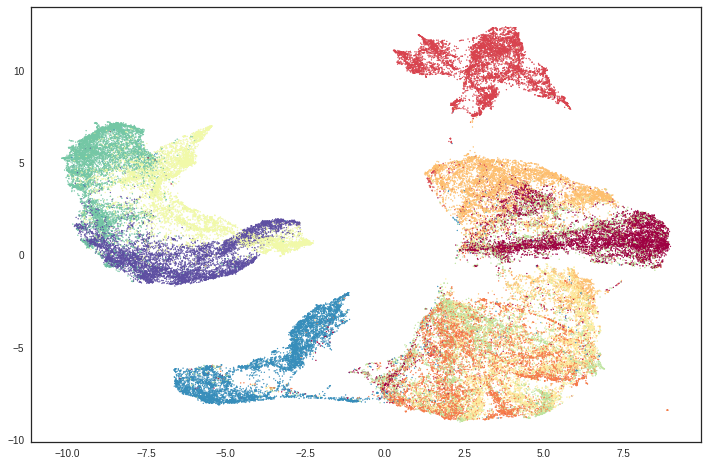

In [50]:
plt.scatter(embedding[:,0], embedding[:,1], c=target, cmap="Spectral", s=1)

In [104]:
train = train.reshape(train.shape[0], 28, 28, 1).astype('float32')
test = test.reshape(test.shape[0], 28, 28, 1).astype('float32')
data = data.reshape(data.shape[0], 28, 28,1).astype('float32')
print(train.shape)
print(test.shape)
print(data.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(70000, 28, 28, 1)


In [0]:
train /= 255.0
test /= 255.0


In [0]:
num_classes = 10
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)
target = keras.utils.to_categorical(target, num_classes)

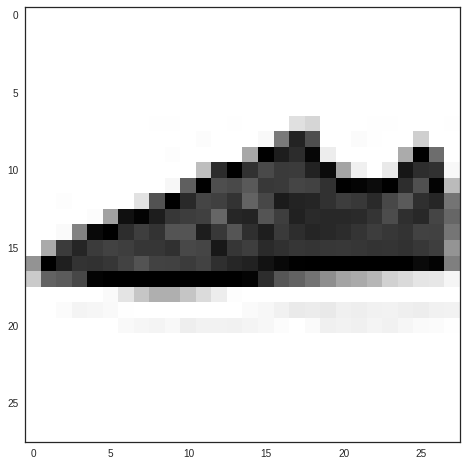

In [54]:
plt.imshow(train[np.random.randint(train.shape[0])][:,:,0])

In [107]:
model = tf.keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
__________

In [0]:
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.pooling import AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input, Conv2D
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape
import keras.backend as K

TH_WEIGHTS_PATH = 'https://github.com/titu1994/Wide-Residual-Networks/releases/download/v1.2/wrn_28_8_th_kernels_th_dim_ordering.h5'
TF_WEIGHTS_PATH = 'https://github.com/titu1994/Wide-Residual-Networks/releases/download/v1.2/wrn_28_8_tf_kernels_tf_dim_ordering.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/titu1994/Wide-Residual-Networks/releases/download/v1.2/wrn_28_8_th_kernels_th_dim_ordering_no_top.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/titu1994/Wide-Residual-Networks/releases/download/v1.2/wrn_28_8_tf_kernels_tf_dim_ordering_no_top.h5'


def WideResidualNetwork(depth=28, width=8, dropout_rate=0.0,
                        include_top=True, weights='cifar10',
                        input_tensor=None, input_shape=None,
                        classes=10, activation='softmax'):
    """Instantiate the Wide Residual Network architecture,
        optionally loading weights pre-trained
        on CIFAR-10. Note that when using TensorFlow,
        for best performance you should set
        `image_dim_ordering="tf"` in your Keras config
        at ~/.keras/keras.json.
        The model and the weights are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            depth: number or layers in the DenseNet
            width: multiplier to the ResNet width (number of filters)
            dropout_rate: dropout rate
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: one of `None` (random initialization) or
                "cifar10" (pre-training on CIFAR-10)..
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(32, 32, 3)` (with `tf` dim ordering)
                or `(3, 32, 32)` (with `th` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if weights not in {'cifar10', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    if weights == 'cifar10' and include_top and classes != 10:
        raise ValueError('If using `weights` as CIFAR 10 with `include_top`'
                         ' as true, `classes` should be 10')

    if (depth - 4) % 6 != 0:
        raise ValueError('Depth of the network must be such that (depth - 4)'
                         'should be divisible by 6.')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_dim_ordering(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_wide_residual_network(classes, img_input, include_top, depth, width,
                                       dropout_rate, activation)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='wide-resnet')

    # load weights
    if weights == 'cifar10':
        if (depth == 28) and (width == 8) and (dropout_rate == 0.0):
            # Default parameters match. Weights for this model exist:

            if K.image_dim_ordering() == 'th':
                if include_top:
                    weights_path = get_file('wide_resnet_28_8_th_dim_ordering_th_kernels.h5',
                                            TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('wide_resnet_28_8_th_dim_ordering_th_kernels_no_top.h5',
                                            TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('You are using the TensorFlow backend, yet you '
                                  'are using the Theano '
                                  'image dimension ordering convention '
                                  '(`image_dim_ordering="th"`). '
                                  'For best performance, set '
                                  '`image_dim_ordering="tf"` in '
                                  'your Keras config '
                                  'at ~/.keras/keras.json.')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('wide_resnet_28_8_tf_dim_ordering_tf_kernels.h5',
                                            TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('wide_resnet_28_8_tf_dim_ordering_tf_kernels_no_top.h5',
                                            TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


def __conv1_block(input):
    x = Conv2D(16, (3, 3), padding='same')(input)

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    return x


def __conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init._keras_shape[1] != 16 * k:
            init = Conv2D(16 * k, (1, 1), activation='linear', padding='same')(init)
    else:
        if init._keras_shape[-1] != 16 * k:
            init = Conv2D(16 * k, (1, 1), activation='linear', padding='same')(init)

    x = Conv2D(16 * k, (3, 3), padding='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = Conv2D(16 * k, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = add([init, x])
    return m


def __conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 32 * k, else create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init._keras_shape[1] != 32 * k:
            init = Conv2D(32 * k, (1, 1), activation='linear', padding='same')(init)
    else:
        if init._keras_shape[-1] != 32 * k:
            init = Conv2D(32 * k, (1, 1), activation='linear', padding='same')(init)

    x = Conv2D(32 * k, (3, 3), padding='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = Conv2D(32 * k, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = add([init, x])
    return m


def ___conv4_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_dim_ordering() == 'th' else -1

    # Check if input number of filters is same as 64 * k, else create convolution2d for this input
    if K.image_dim_ordering() == 'th':
        if init._keras_shape[1] != 64 * k:
            init = Conv2D(64 * k, (1, 1), activation='linear', padding='same')(init)
    else:
        if init._keras_shape[-1] != 64 * k:
            init = Conv2D(64 * k, (1, 1), activation='linear', padding='same')(init)

    x = Conv2D(64 * k, (3, 3), padding='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = Conv2D(64 * k, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = add([init, x])
    return m


def __create_wide_residual_network(nb_classes, img_input, include_top, depth=28,
                                   width=8, dropout=0.0, activation='softmax'):
    ''' Creates a Wide Residual Network with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input tensor or layer
        include_top: Flag to include the last dense layer
        depth: Depth of the network. Compute N = (n - 4) / 6.
               For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
               For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
               For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
        width: Width of the network.
        dropout: Adds dropout if value is greater than 0.0
    Returns:a Keras Model
    '''

    N = (depth - 4) // 6

    x = __conv1_block(img_input)
    nb_conv = 4

    for i in range(N):
        x = __conv2_block(x, width, dropout)
        nb_conv += 2

    x = MaxPooling2D((2, 2))(x)

    for i in range(N):
        x = __conv3_block(x, width, dropout)
        nb_conv += 2

    x = MaxPooling2D((2, 2))(x)

    for i in range(N):
        x = ___conv4_block(x, width, dropout)
        nb_conv += 2

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, activation=activation)(x)

    return x

In [109]:
wrnm = WideResidualNetwork(weights = None, input_shape = train.shape[1:], depth=40, width=10, dropout_rate = 0.2)
wrnm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_149 (Conv2D)             (None, 28, 28, 16)   160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_137 (BatchN (None, 28, 28, 16)   64          conv2d_149[0][0]                 
__________________________________________________________________________________________________
activation_137 (Activation)     (None, 28, 28, 16)   0           batch_normalization_137[0][0]    
__________________________________________________________________________________________________
conv2d_151

(28, 28, 1)

In [0]:
from keras.optimizers import SGD,Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

#TODO : ending up ignoring this for now. Need to go back to it tuning rate & hyperparam schedule
#optim = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

generator = ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./28,
                               height_shift_range=5./28,
                               horizontal_flip=True)

#generator.fit(train, seed=0, augment=True)

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

model.compile(loss='categorical_crossentropy',
             optimizer = 'Adam',
             metrics=['accuracy'])

wrnm.compile(loss='categorical_crossentropy',
             optimizer = 'Adam',
             metrics=['accuracy'])

In [1]:
history = wrnm.fit(train,
         train_labels,
         batch_size=32,
         epochs=20,
         validation_data=(test, test_labels),
         callbacks=[checkpointer])

NameError: ignored

In [75]:
score = model.evaluate(test, test_labels, verbose=0)
print(score[1])

SyntaxError: ignored

In [78]:
history

SyntaxError: ignored